# Marmoset internode connectivity mPFC-dlPFC-PCC-PPC

In [1]:
import os, sys
import tempfile
import nibabel as nib
import numpy as np
# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm

surfaces = dict()
surfaces['human_lh'] = "/mnt/WD10TB/datasets/data_view_crossspecies/human/surfaces/S1200.L.very_inflated_MSMAll.10k_fs_LR.surf.gii"
surfaces['human_rh'] = "/mnt/WD10TB/datasets/data_view_crossspecies/human/surfaces/S1200.R.very_inflated_MSMAll.10k_fs_LR.surf.gii"
surfaces['marmoset_lh'] = "/mnt/WD10TB/datasets/data_view_crossspecies/marmoset/surfaces/surfFS.lh.pial.inflated.10k.surf.gii"
surfaces['marmoset_rh'] = "/mnt/WD10TB/datasets/data_view_crossspecies/marmoset/surfaces/surfFS.rh.pial.inflated.10k.surf.gii"

# SPECIFY INPUTS
sing_shell="singularity exec -B /mnt/WD10TB -B / /home/geoff/Desktop/containers/fmriprep_ciftify-1.3.2-2.3.3"
jointgrad_dir = "../data/data_xspecies/joint_eigenmap.human-100UR.marmoset-NIH.thr-corr-0.001.norm"

In [2]:
def get_joint_gradient(species,gradient_id,hemi,jointgrad_dir=jointgrad_dir,sing_shell=sing_shell):
    
    def read_dscalar(dscalar,hemi):
        # Set-up tmpdir
        tmpdir = tempfile.TemporaryDirectory()
        # Read data
        left_func = f"{os.path.join(tmpdir.name,'left_func.func.gii')}"
        right_func = f"{os.path.join(tmpdir.name,'right_func.func.gii')}"
        cmd = f"{sing_shell} wb_command -cifti-separate {dscalar} COLUMN -metric CORTEX_LEFT {left_func} -metric CORTEX_RIGHT {right_func}"
        os.system(cmd)
        if hemi == 'lh':
            read_func = left_func
        elif hemi == 'rh':
            read_func = right_func
        else:
            NotImplemented
        
        return nib.load(read_func).agg_data()
        
    gradient_path = os.path.join(jointgrad_dir,f"joint_eigenmap_{species}.dscalar.nii")
    data = read_dscalar(gradient_path,hemi)
    data = data[gradient_id]
    
    return data

def get_dscalar(dscalar,sing_shell=sing_shell):
    
    def read_dscalar(dscalar,hemi):
        # Set-up tmpdir
        tmpdir = tempfile.TemporaryDirectory()
        # Read data
        left_func = f"{os.path.join(tmpdir.name,'left_func.func.gii')}"
        right_func = f"{os.path.join(tmpdir.name,'right_func.func.gii')}"
        cmd = f"{sing_shell} wb_command -cifti-separate {dscalar} COLUMN -metric CORTEX_LEFT {left_func} -metric CORTEX_RIGHT {right_func}"
        os.system(cmd)
        if hemi == 'lh':
            read_func = left_func
        elif hemi == 'rh':
            read_func = right_func
        else:
            NotImplemented
        
        return nib.load(read_func).agg_data()
        
    data_lh = read_dscalar(dscalar,'lh')
    data_rh = read_dscalar(dscalar,'rh')
    
    return data_lh, data_rh


def get_gradient_distribution(species,option,datadir="notebook_data/2_DMN_nodes"):
    """
    Function to grab gradient values from the somatomotor-DMN gradient
    """
    def get_roi(species,rois):
        """
        * rois is '+'-delimited
        Human ROIs: dlPFC, PCC, PPC
        Marmoset ROIs: dlPFC [A8aD,A6DR], PCC [PGM,A23a,A23b,A29d,A30],
                       PPC [LIP,MIP,AIP,VIP], mPFC [A32,A10,A32V]
        """
        if species == 'human':
            if isinstance(rois, str) and '+' not in rois:
                roi = rois
                human_dscalar = f"{datadir}/ROIs/{species}/human.HCP_Parcellation.10k.roi-{roi}.dscalar.nii"
                values = np.concatenate((get_joint_gradient(species,1,'lh')[np.where(get_dscalar(human_dscalar)[0]==1)],
                                         get_joint_gradient(species,1,'rh')[np.where(get_dscalar(human_dscalar)[1]==1)]))
            else:
                first_flag = True
                for roi in rois.split('+'):
                    human_dscalar = f"{datadir}/ROIs/{species}/human.HCP_Parcellation.10k.roi-{roi}.dscalar.nii"
                    values_ = np.concatenate((get_joint_gradient(species,1,'lh')[np.where(get_dscalar(human_dscalar)[0]==1)],
                                             get_joint_gradient(species,1,'rh')[np.where(get_dscalar(human_dscalar)[1]==1)]))
                    if first_flag:
                        values = values_
                        first_flag = False
                    else:
                        values = np.concatenate((values,values_))
        
        elif species == 'marmoset':
            if isinstance(rois, str) and '+' not in rois:
                roi = rois
                marm_dscalar = f"{datadir}/ROIs/{species}/surfFS.MBM_cortex_vPaxinos.10k.roi-{roi}.dscalar.nii"
                values = np.concatenate((get_joint_gradient(species,1,'lh')[np.where(get_dscalar(marm_dscalar)[0]==1)],
                                         get_joint_gradient(species,1,'rh')[np.where(get_dscalar(marm_dscalar)[1]==1)]))
            else:
                first_flag = True
                for roi in rois.split('+'):
                    marm_dscalar = f"{datadir}/ROIs/{species}/surfFS.MBM_cortex_vPaxinos.10k.roi-{roi}.dscalar.nii"
                    values_ = np.concatenate((get_joint_gradient(species,1,'lh')[np.where(get_dscalar(marm_dscalar)[0]==1)],
                                              get_joint_gradient(species,1,'rh')[np.where(get_dscalar(marm_dscalar)[1]==1)]))
                    if first_flag:
                        values = values_
                        first_flag = False
                    else:
                        values = np.concatenate((values,values_))
                        
        else:
            NotImplemented
        
        return values
        
    # human-related functions
    if species == 'human' and option == 'DMN':
        human_dscalar = f"{datadir}/ROIs/human/Ji_2019_human_Default.dscalar.nii"
        values = np.concatenate((get_joint_gradient(species,1,'lh')[np.where(get_dscalar(human_dscalar)[0]==1)],
                                 get_joint_gradient(species,1,'rh')[np.where(get_dscalar(human_dscalar)[1]==1)]))
        return values
    elif species == 'human' and option == 'DMN_no_mPFC':
        roi_list = "PGi+PGs+8Ad+8Av+7m+31pd+31pv+v23ab+POS1+d23ab+31a+23d"
        return get_roi("human",roi_list)
    elif species == 'human' and option != "YEO" and option != "handdrawn":
        return get_roi("human",option)
    # marmoset-related functions
    elif species == 'marmoset' and option == "strict":
        roi_list = "A8aD+PGM+LIP" # INCLUDE ONLY PEAK ROIS FOR EACH DMN NODE (dlPFC/PCC/PPC) according to Liu et al 2019
        return get_roi("marmoset",roi_list)
    elif species == 'marmoset' and option == "lenient":
        roi_list = "A8aD+A6DR+PGM+A23a+A23b+A29d+A30+LIP+MIP+AIP+VIP" # INCLUDE ALL ROIS EXCLUDING mPFC
        return get_roi("marmoset",roi_list)
    elif species == 'marmoset' and option != "lenient" and option != "strict":
        return get_roi("marmoset",option)
    else:
        NotImplemented
        
def get_rfmri_data(species,rfmri_dir):
    
    def summarize_fn(dtseries,species):
        if species == 'human':
            dtseries = dtseries.split('/')[-1].replace('.wmcsf_reg.s6.cortex.dtseries.nii','').replace('.rfMRI_','_')
            return dtseries
        elif species == 'marmoset':
            dtseries = dtseries.replace('.rfMRI.wmcsf_reg.s1.5.cortex.dtseries.nii','')
            return dtseries
        else:
            NotImplemented
        return dtseries

    all_data = os.listdir(rfmri_dir[species])
    data = {}
    data['id'] = []
    data['lh'] = []
    data['rh'] = []
    for ix, dtseries in tqdm(enumerate(all_data)):
        fn = summarize_fn(dtseries,species)
        data['id'].append(fn)
        
        # Comment out when run for the first time
        """dtseries = os.path.join(rfmri_dir[species],dtseries)
        lh_data, rh_data = get_dscalar(dtseries)
        n_tp = len(lh_data)
        n_coords = lh_data[0].shape[0]
        
        data_temp = np.zeros((n_coords,n_tp))
        for ix_,row in enumerate(lh_data):
            data_temp[:,ix_] = row
        data_temp = (data_temp - data_temp.mean(1,keepdims=True))/(data_temp.std(1,keepdims=True))
        data['lh'].append(data_temp)
        data_temp = np.zeros((n_coords,n_tp))
        for ix_,row in enumerate(rh_data):
            data_temp[:,ix_] = row    
        data_temp = (data_temp - data_temp.mean(1,keepdims=True))/(data_temp.std(1,keepdims=True))
        data['rh'].append(data_temp)"""
        
    return data
    
def get_timeseries(roi,species,rfmri_data,datadir="notebook_data/2_DMN_nodes"):
    
    print(roi,species)
    
    def get_roi_coords(species,roi):
        
        """
        Human ROIs: dlPFC [8Ad,8Av], PCC [7m,31pd,31pv,v23ab,POS1,d23ab,31a,23d],
                    PPC [PGi,PGs], mPFC [9p,9a,9m,10d,10pp,10v,10r,p32,a24,s32,25]
        Marmoset ROIs: dlPFC [A8aD,A6DR], PCC [PGM,A23a,A23b,A29d,A30],
                       PPC [LIP,MIP,AIP,VIP], mPFC [A32,A10,A32V]
        """
        if species == 'human':
            human_dscalar = f"{datadir}/ROIs/{species}/human.HCP_Parcellation.10k.roi-{roi}.dscalar.nii"
            lh_coords = np.where(get_dscalar(human_dscalar)[0]==1)
            rh_coords = np.where(get_dscalar(human_dscalar)[1]==1)

        elif species == 'marmoset':
            marm_dscalar = f"{datadir}/ROIs/{species}/surfFS.MBM_cortex_vPaxinos.10k.roi-{roi}.dscalar.nii"
            lh_coords = np.where(get_dscalar(marm_dscalar)[0]==1)
            rh_coords = np.where(get_dscalar(marm_dscalar)[1]==1)
        
        return lh_coords,rh_coords
    
    data = {}
    data['id'] = []
    data['lh'] = []
    data['rh'] = []
    lh_coords, rh_coords = get_roi_coords(species,roi)
    for ix,ts_data in enumerate(rfmri_data['lh']):
        fn = rfmri_data['id'][ix]
        data['id'].append(fn)
        extracted_ts = ts_data[lh_coords]
        data['lh'].append(extracted_ts)
    for ix,ts_data in enumerate(rfmri_data['rh']):
        extracted_ts = ts_data[rh_coords]
        data['rh'].append(extracted_ts)
        
    return data

class connectivity_info:
    
    def __init__(self,id_,cortex_ts,dmn_ts,dmn_order):
        self.id = id_
        self.cortex_ts = cortex_ts
        self.dmn_ts = dmn_ts
        self.dmn_order = dmn_order
        self.n_runs = len(self.cortex_ts)
        
    def process(self):
        first_flag = True
        for run in range(self.n_runs):
            if first_flag:
                self.dmn_to_dmn = np.corrcoef(self.dmn_ts[run],self.dmn_ts[run])[:len(self.dmn_order),:][:,:len(self.dmn_order)]
                self.dmn_to_cortex = np.corrcoef(self.cortex_ts[run],self.dmn_ts[run])[:,-len(self.dmn_order):][:-len(self.dmn_order),:]
                first_flag = False
            else:
                self.dmn_to_dmn += np.corrcoef(self.dmn_ts[run],self.dmn_ts[run])[:len(self.dmn_order),:][:,:len(self.dmn_order)]
                self.dmn_to_cortex += np.corrcoef(self.cortex_ts[run],self.dmn_ts[run])[:,-len(self.dmn_order):][:-len(self.dmn_order),:]
        self.dmn_to_dmn /= self.n_runs
        self.dmn_to_cortex /= self.n_runs
        del self.dmn_ts, self.cortex_ts

def condense_data_by_participant(species,species_id,rfmri_data,ts_data,pkldir=f"notebook_data/2_DMN_nodes/pkl/main"):
    
    import pickle
            
    def get_roi_from_ts():
        first_roi_flag = True
        roi_list = []
        for hemi in ['lh','rh']:
            for roi in ts_data.keys():
                roi_list.append(f"{roi} {hemi}")
                if species in roi:
                    if first_roi_flag:
                        roi_ts = ts_data[roi][hemi][ix].mean(0,keepdims=True)
                        first_roi_flag = False
                    else:
                        roi_ts = np.vstack((roi_ts,ts_data[roi][hemi][ix].mean(0,keepdims=True)))
                        
        return roi_ts,roi_list
    
    id_list = []
    for participant_id in tqdm(species_id):
        id_list.append(participant_id)
        fn = os.path.join(pkldir,f"{participant_id}.pkl")
        if os.path.exists(fn):
            continue
        wholebrain_ts = []
        roi_ts = []
        for ix, search_id in enumerate(rfmri_data['id']):
            if participant_id in search_id:
                wholebrain_ts.append(np.concatenate((rfmri_data['lh'][ix],rfmri_data['rh'][ix]),axis=0))
                roi_ts.append(get_roi_from_ts()[0])
        data_ = connectivity_info(participant_id,wholebrain_ts,roi_ts,get_roi_from_ts()[1])
        data_.process()
        f=open(fn,"wb")
        pickle.dump(data_,f,2)
        
    return id_list

def get_unique_ids(rfmri_human,rfmri_marmoset,species):
    
    if species == 'human':
        ids = list(set([scanid.split('_')[0] for scanid in rfmri_human['id']]))
    elif species == 'marmoset':
        ids = list(set([scanid.split('_')[0] for scanid in rfmri_marmoset['id']]))
        
    return ids

In [3]:
rfmri_dir = dict()
rfmri_dir['marmoset'] = "/mnt/WD10TB/datasets/data_marmosetbrainconnectome/raw/preprocess_data/cortex_data/10k/cifti"
rfmri_dir['human'] = "/mnt/WD10TB/datasets/data_HCP/preprocess_data/cortex_data/10k/cifti"

""" marmoset mPFC """
rfmri_marmoset = get_rfmri_data('marmoset',rfmri_dir)
ts_data = {}
for roi_ in ['A32','A8aD','PGM','LIP']:
    ts_data[f"{roi_}_marmoset"] = get_timeseries(roi_,'marmoset',rfmri_marmoset)
marmoset_ids = get_unique_ids('0',rfmri_marmoset,'marmoset')
marmoset_data = condense_data_by_participant('marmoset',marmoset_ids,rfmri_marmoset,ts_data,pkldir=f"notebook_data/2_DMN_nodes/pkl/marmoset_mPFC_dlPFC_PCC_PPC")
del ts_data, rfmri_marmoset

0it [00:00, ?it/s]<ipython-input-2-c48b7c3f8f9a>:157: RuntimeWarning: invalid value encountered in true_divide
  data_temp = (data_temp - data_temp.mean(1,keepdims=True))/(data_temp.std(1,keepdims=True))
<ipython-input-2-c48b7c3f8f9a>:162: RuntimeWarning: invalid value encountered in true_divide
  data_temp = (data_temp - data_temp.mean(1,keepdims=True))/(data_temp.std(1,keepdims=True))
246it [25:08,  6.13s/it]


A32 marmoset
A8aD marmoset
PGM marmoset
LIP marmoset


100%|██████████| 28/28 [24:37<00:00, 52.75s/it] 


In [6]:
import pickle

pkldir = f"notebook_data/2_DMN_nodes/pkl/marmoset_mPFC_dlPFC_PCC_PPC"
def read_pkl(participant_id,pkldir=pkldir):
    f = open(os.path.join(pkldir,f"{participant_id}.pkl"), 'rb')
    data = pickle.load(f)
    return data
             
def get_dmn_to_dmn_mean(ids,pkldir):
    con = np.zeros((read_pkl(ids[0],pkldir).dmn_to_dmn.shape))
    for idx in range(len(ids)):
        con += read_pkl(ids[idx],pkldir).dmn_to_dmn
    con /= con[0,0]
    np.fill_diagonal(con,0)
    return con

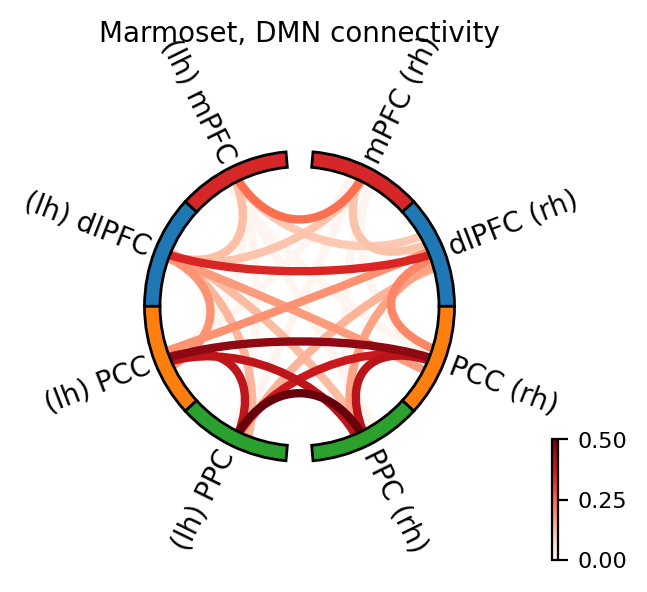

In [19]:
con1 = get_dmn_to_dmn_mean(marmoset_ids,pkldir)

from mne.viz import plot_connectivity_circle,circular_layout
# Node names
node_names = ['(lh) mPFC','(lh) dlPFC','(lh) PCC','(lh) PPC','mPFC (rh)','dlPFC (rh)','PCC (rh)','PPC (rh)'] # order idx by square matrix
node_order = ['(lh) mPFC','(lh) dlPFC','(lh) PCC','(lh) PPC','PPC (rh)','PCC (rh)','dlPFC (rh)','mPFC (rh)'] # What I want
# Used to color-code same node, different hemisphere the same colour
node_colors = cm.get_cmap('tab10',10)
node_colors = [node_colors(3),node_colors(0),node_colors(1),node_colors(2),
               node_colors(3),node_colors(0),node_colors(1),node_colors(2)]
# Used to re-order conn matrix
n_rois = len(node_names)
node_angles = circular_layout(node_names, node_order, start_pos=90,
                              group_boundaries=[0, n_rois/2])

fig = plt.figure(num=None, figsize=(4, 4), facecolor='white',dpi=200)
fig,ax=plot_connectivity_circle(con1,node_names,
                                colormap='Reds',facecolor='white', textcolor='black',
                                linewidth=3,vmin=0,vmax=.5,
                                node_angles=node_angles,node_linewidth=1.,node_colors=node_colors,
                                title='Marmoset, DMN connectivity',
                                fontsize_names=10,fontsize_title=10,
                                fig=fig,subplot=111)
fig.savefig(os.path.join('figures',f"DMN_ROIs_conn_marmoset_wMedialPFC.jpg"),dpi=1080,bbox_inches='tight')

sub-m28


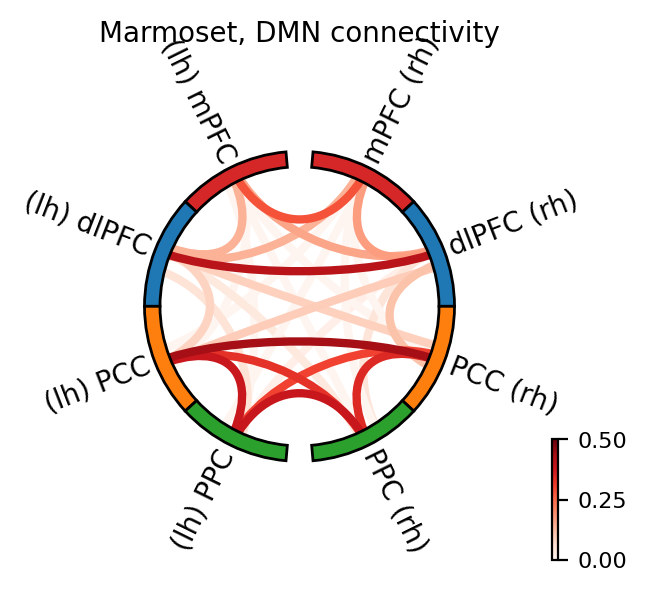

sub-m15


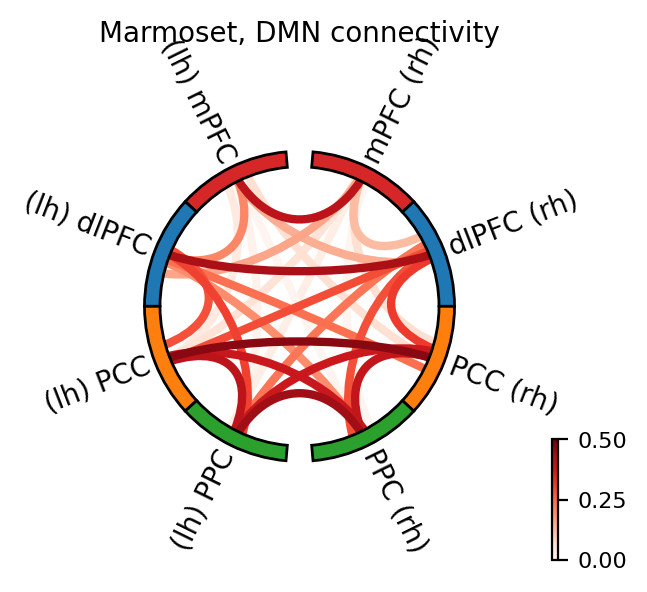

sub-m16


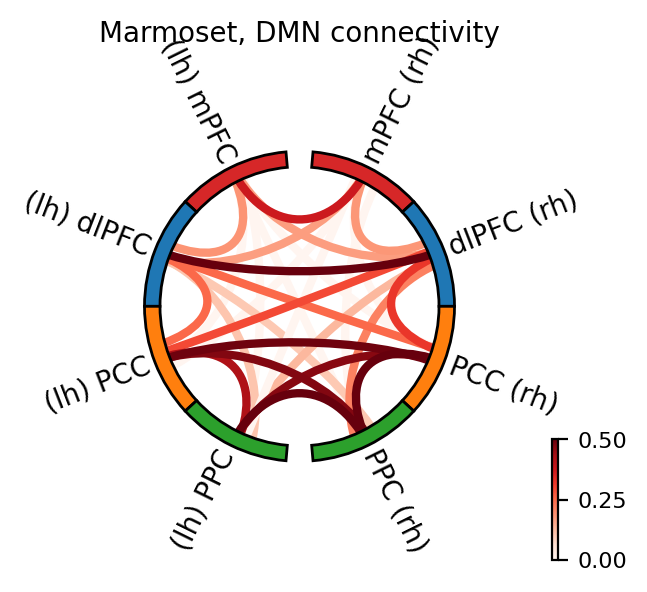

sub-m6


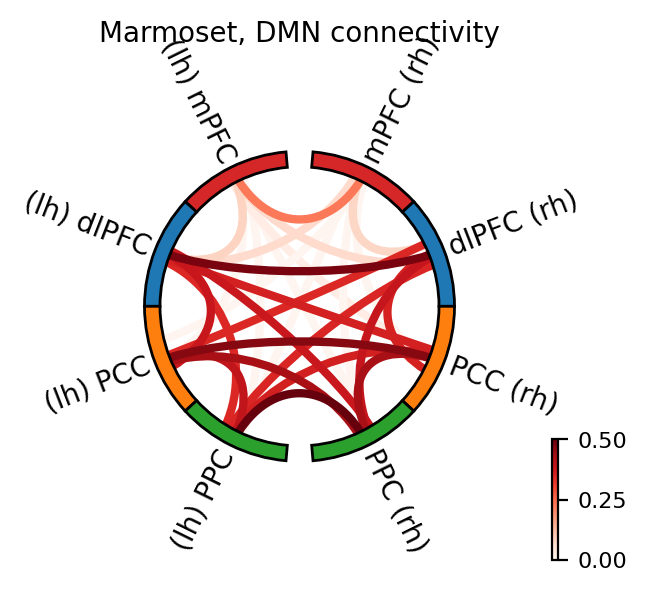

sub-m19


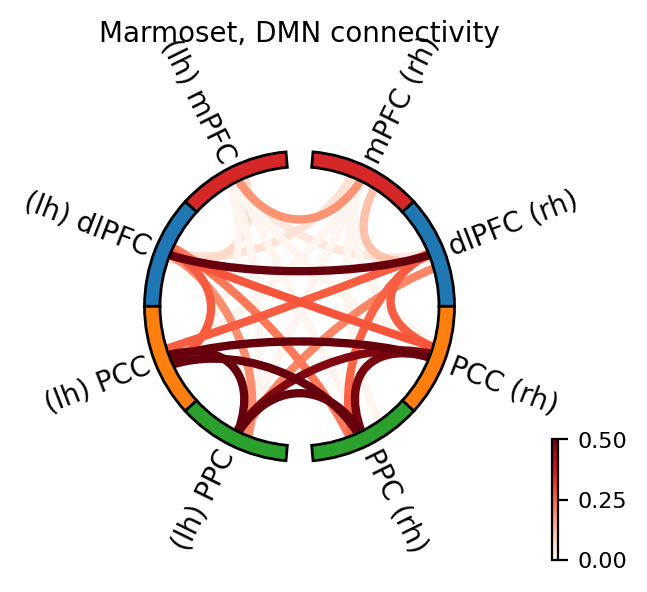

sub-m5


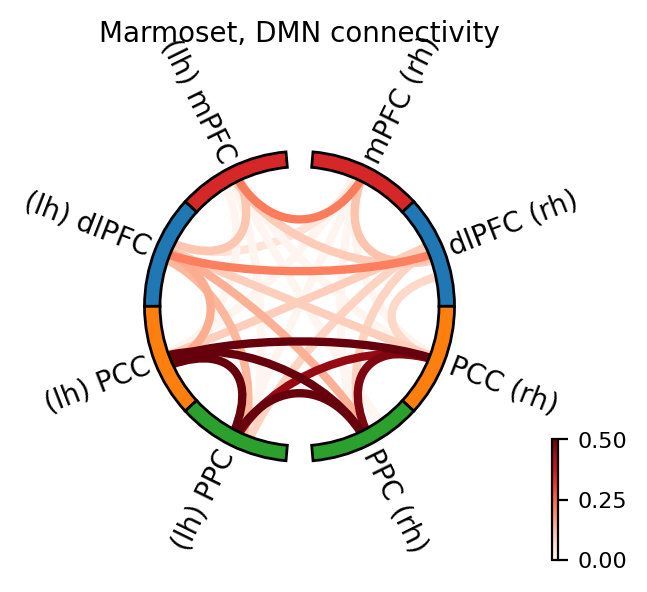

sub-m18


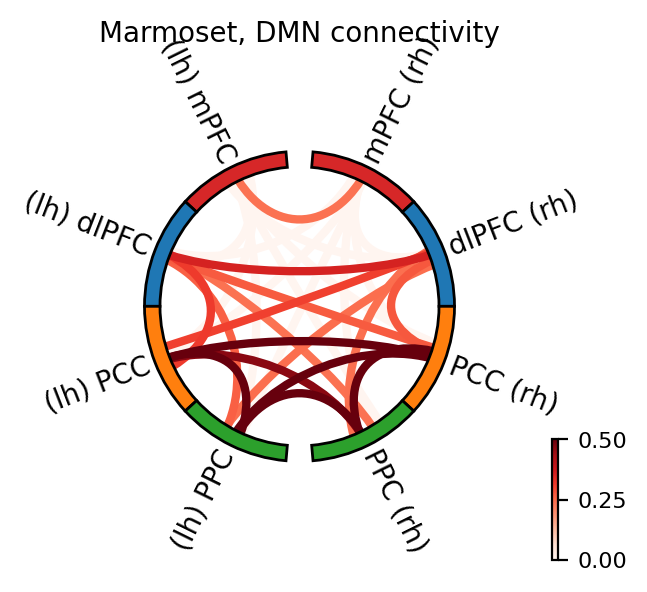

sub-m20


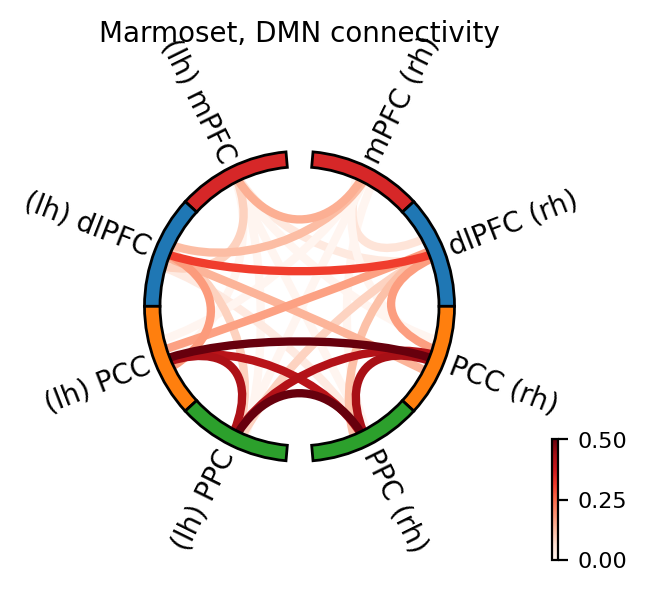

sub-m7


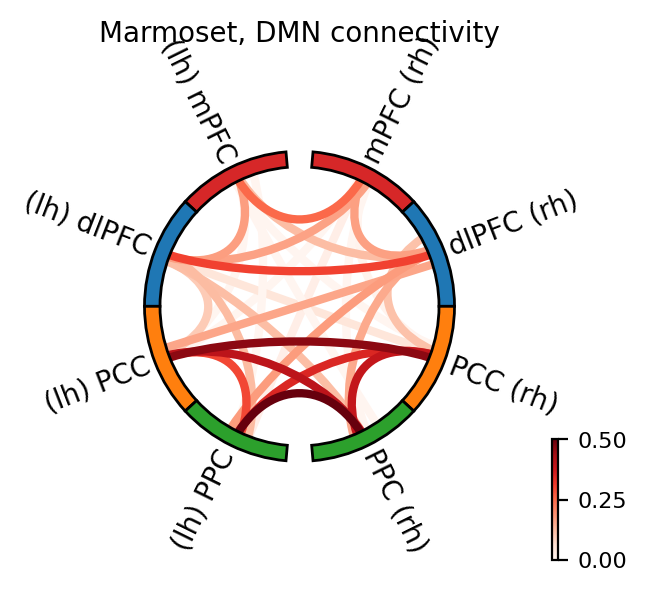

sub-m29


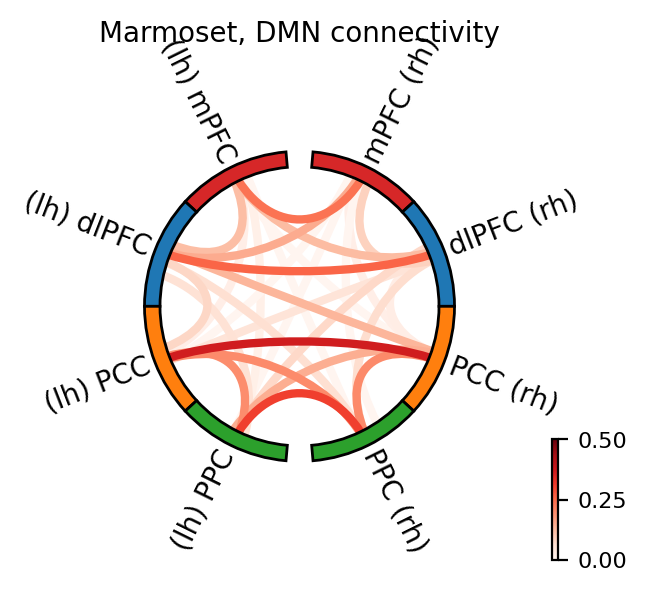

sub-m25


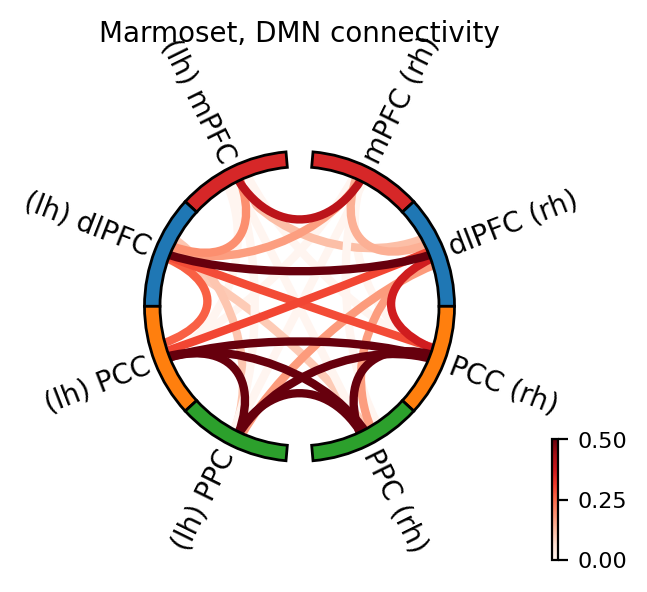

sub-m23


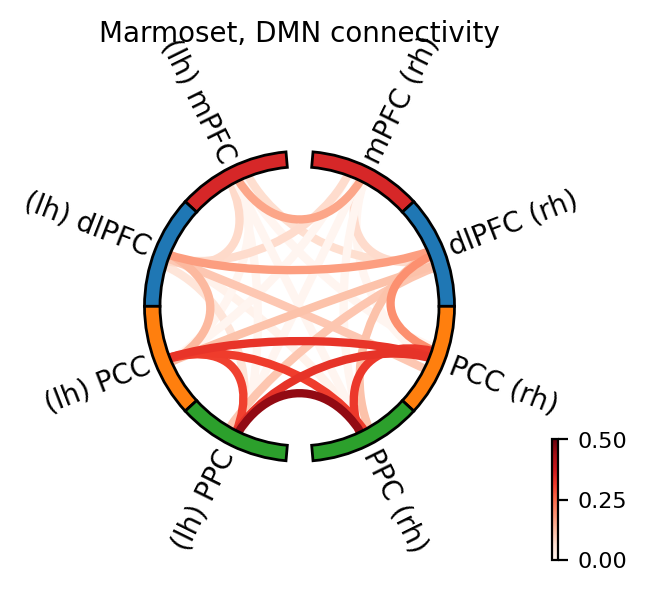

sub-m14


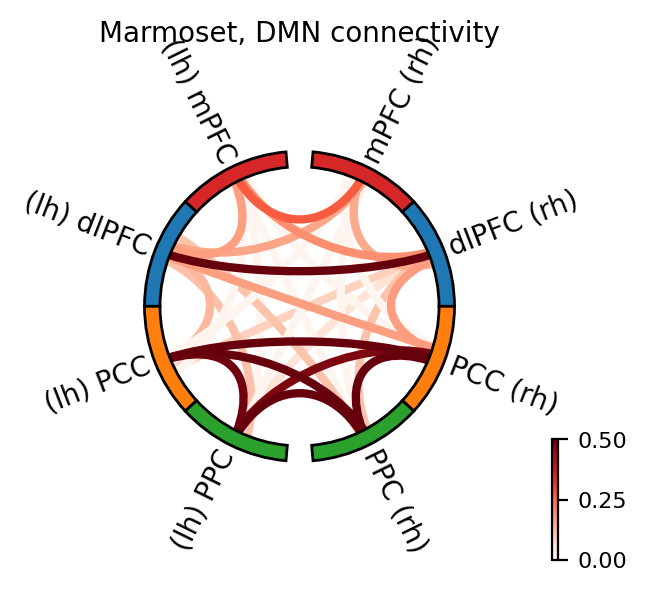

sub-m3


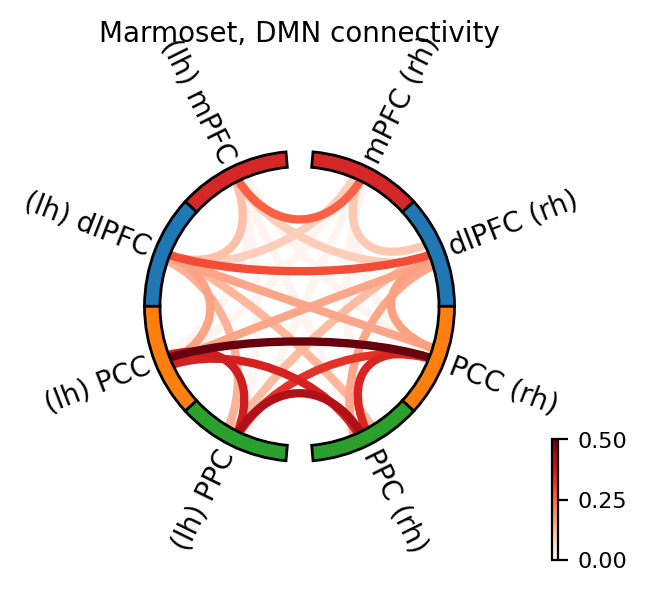

sub-m24


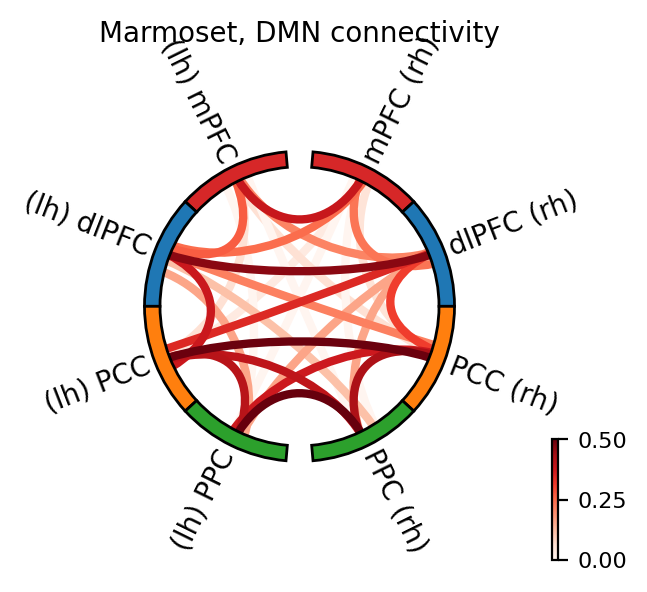

sub-m30


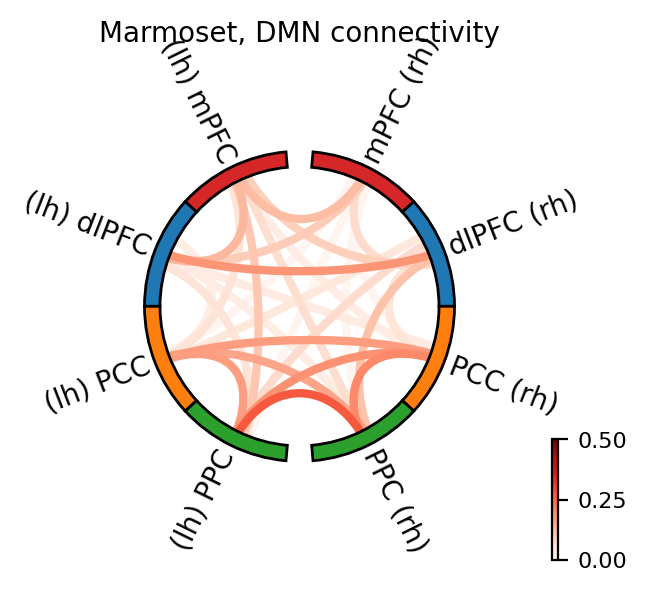

sub-m31


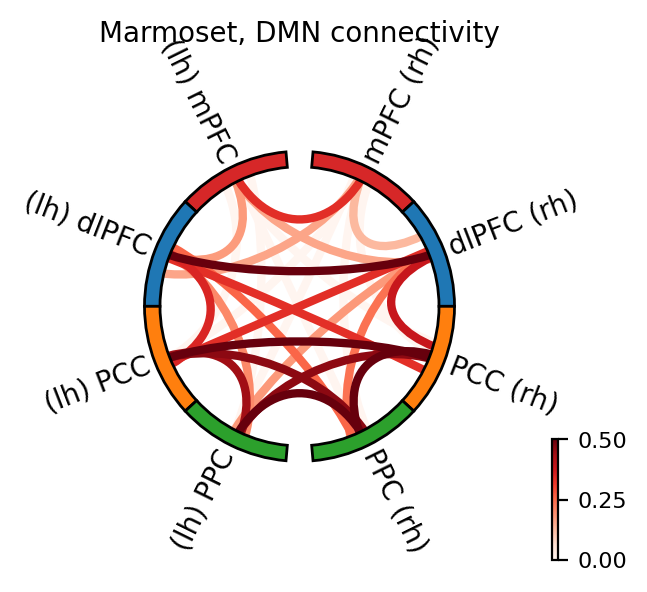

sub-m4


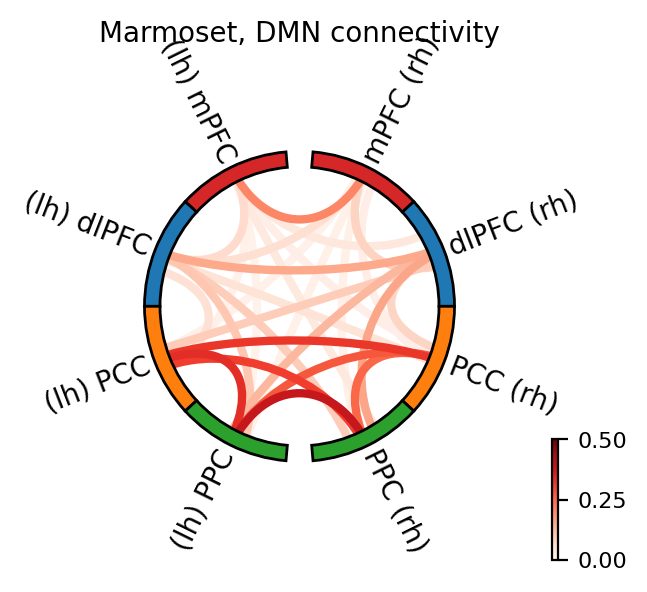

sub-m8


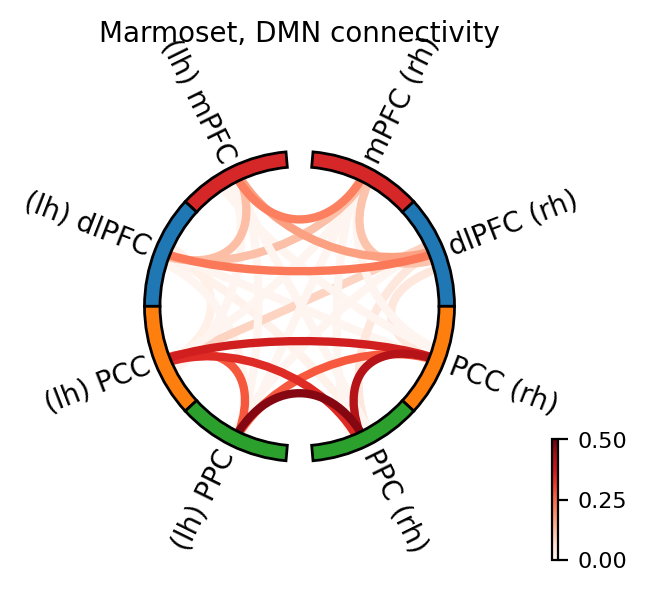

sub-m11


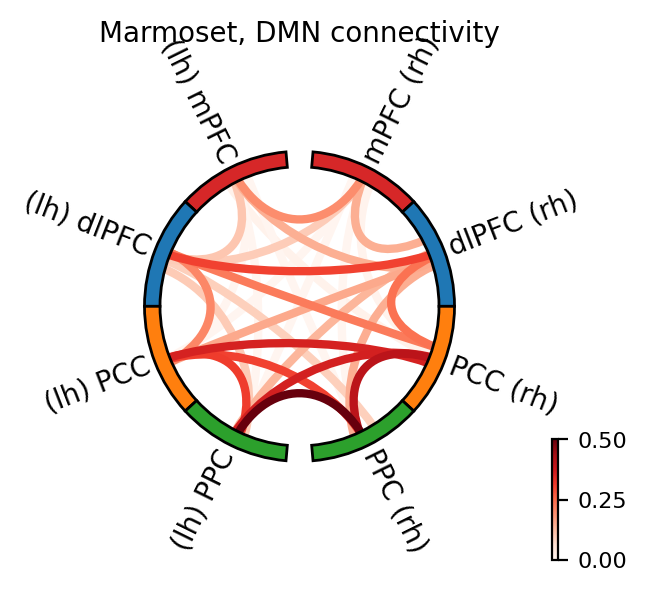

sub-m10


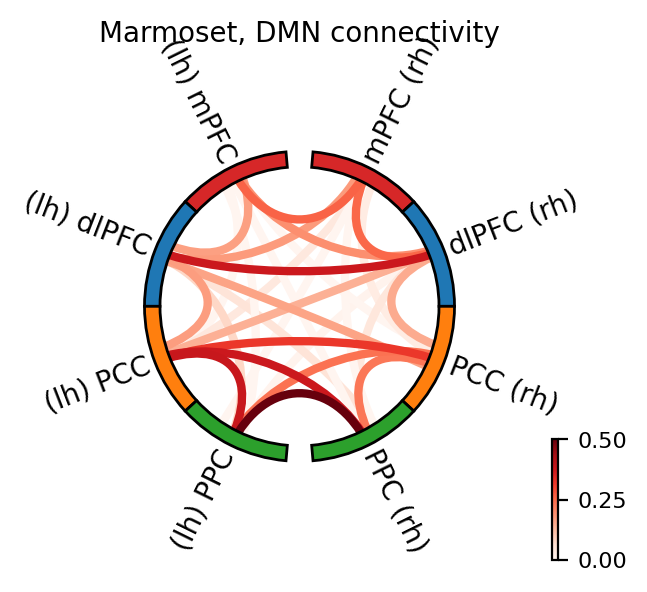

sub-m22


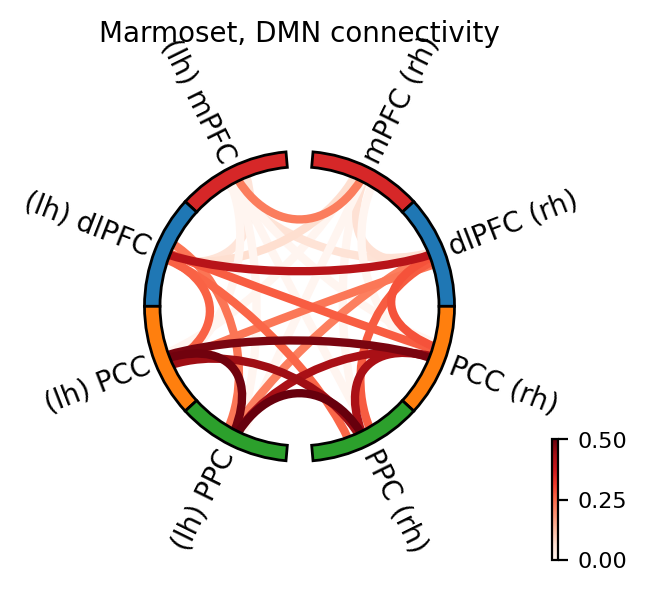

sub-m1


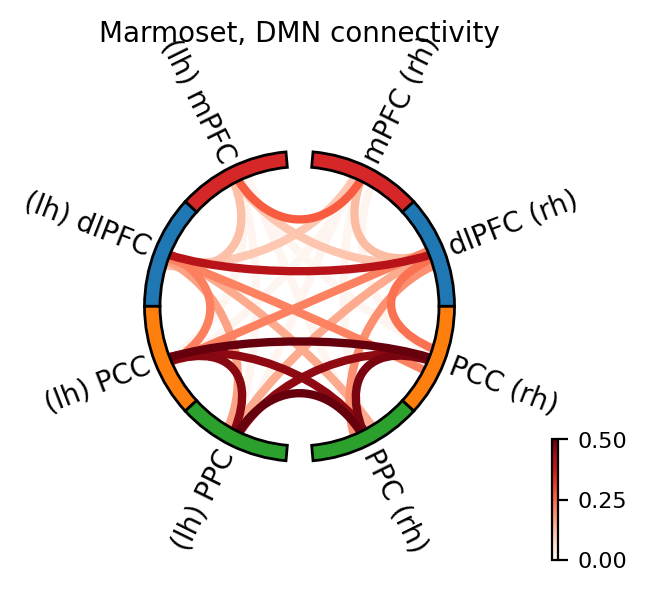

sub-m12


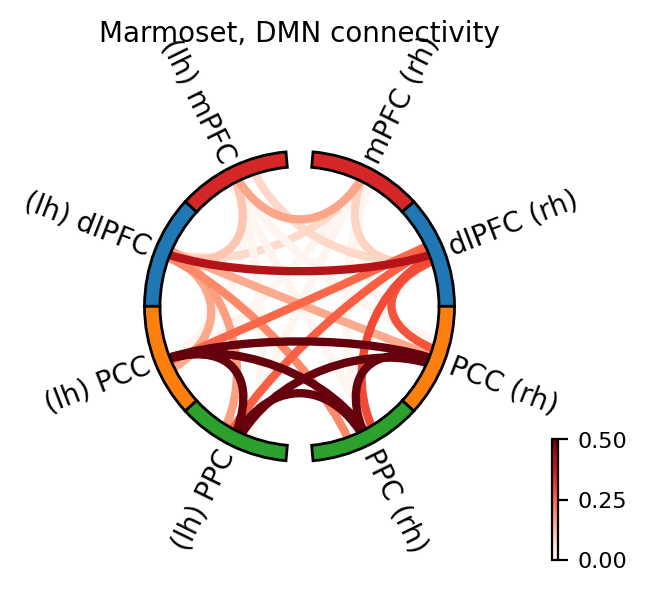

sub-m2


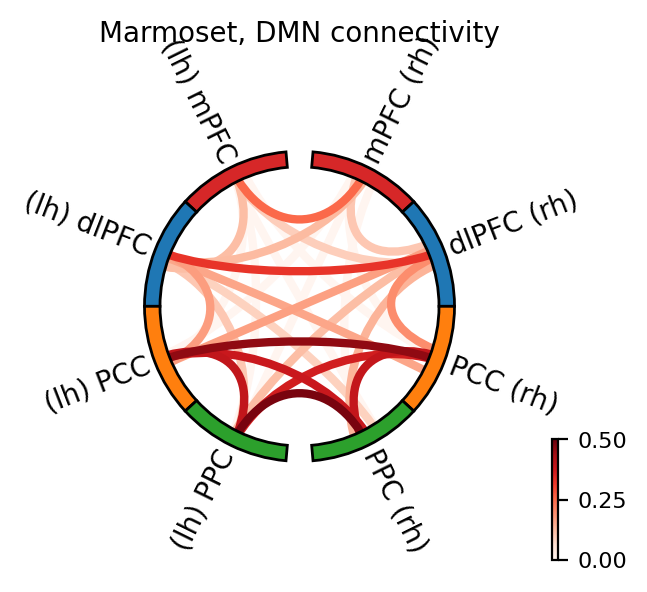

sub-m26


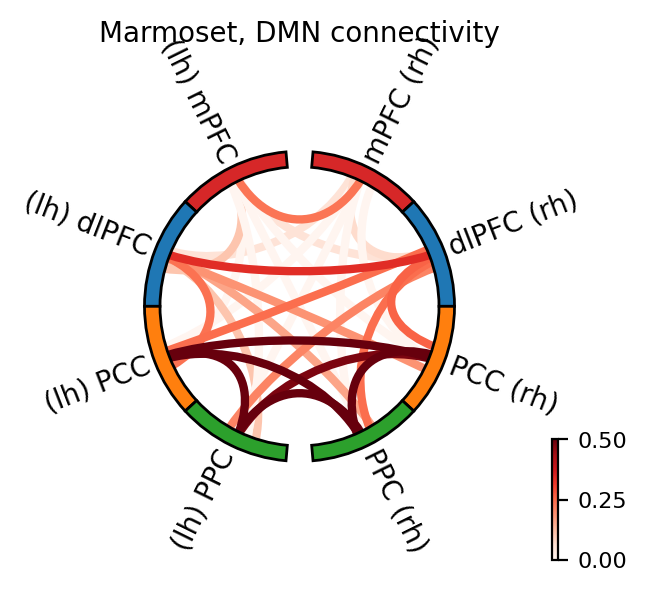

sub-m21


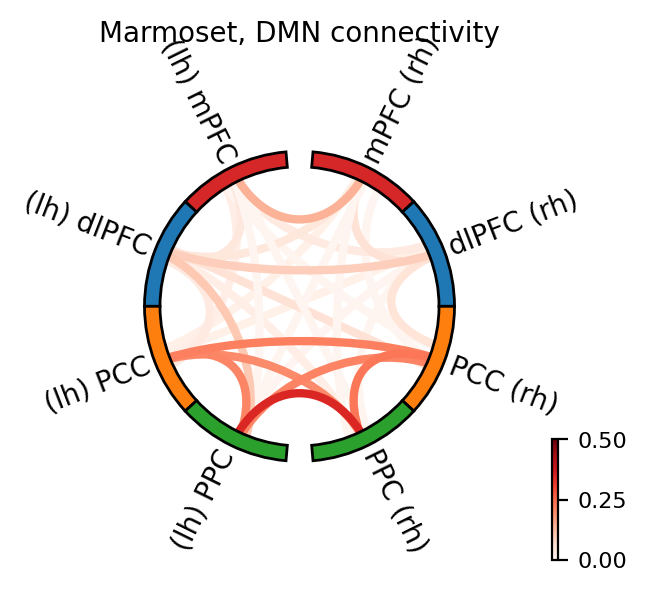

sub-m27


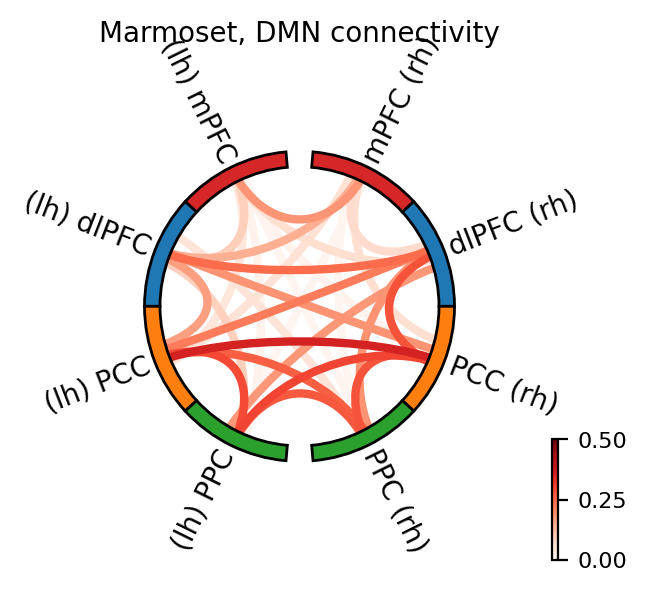

In [20]:
for i in marmoset_ids:
    
    print(i)
    con1 = get_dmn_to_dmn_mean([i],pkldir)

    from mne.viz import plot_connectivity_circle,circular_layout
    # Node names
    node_names = ['(lh) mPFC','(lh) dlPFC','(lh) PCC','(lh) PPC','mPFC (rh)','dlPFC (rh)','PCC (rh)','PPC (rh)'] # order idx by square matrix
    node_order = ['(lh) mPFC','(lh) dlPFC','(lh) PCC','(lh) PPC','PPC (rh)','PCC (rh)','dlPFC (rh)','mPFC (rh)'] # What I want
    # Used to color-code same node, different hemisphere the same colour
    node_colors = cm.get_cmap('tab10',10)
    node_colors = [node_colors(3),node_colors(0),node_colors(1),node_colors(2),
                   node_colors(3),node_colors(0),node_colors(1),node_colors(2)]
    # Used to re-order conn matrix
    n_rois = len(node_names)
    node_angles = circular_layout(node_names, node_order, start_pos=90,
                                  group_boundaries=[0, n_rois/2])

    fig = plt.figure(num=None, figsize=(4, 4), facecolor='white',dpi=200)
    fig,ax=plot_connectivity_circle(con1,node_names,
                                    colormap='Reds',facecolor='white', textcolor='black',
                                    linewidth=3,vmin=0,vmax=.5,
                                    node_angles=node_angles,node_linewidth=1.,node_colors=node_colors,
                                    title='Marmoset, DMN connectivity',
                                    fontsize_names=10,fontsize_title=10,
                                    fig=fig,subplot=111)
    fig.savefig(os.path.join('figures','DMN_ROIs_conn_marmoset_individual',f"{i}.jpg"),dpi=1080,bbox_inches='tight')